In [79]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

url = "https://vip-prod-service-00-azapp.azurewebsites.net/_layouts/CepsData.asmx"

options = {
    "Content-Type": "text/xml; charset=utf-8",
    "SOAPAction": "https://www.ceps.cz/CepsData/AktualniSystemovaOdchylkaCR"
}

In [80]:
# Get the current time
five_hours_ago = datetime.datetime.now() - datetime.timedelta(hours=5)

# Set the timezone offset manually
timezone_offset = -300  # Offset for UTC-5:00 (5 hours * 60 minutes)

# Convert to the desired format
formatted_date = five_hours_ago.strftime("%Y-%m-%dT%H:%M:%S")
timezone_offset_formatted = f"{'' if timezone_offset < 0 else '+'}"
# {abs(timezone_offset)//60:02d}:00"

five_hours_ago_formatted = formatted_date + timezone_offset_formatted
print(five_hours_ago_formatted)
# print("2023-06-03T00:00:00")

date_to = datetime.datetime.now()
formatted_date_to = date_to.strftime("%Y-%m-%dT%H:%M:%S")
timezone_offset_formatted_to = f"{'' if timezone_offset < 0 else '+'}" 
print(formatted_date_to)

2023-06-05T03:31:46
2023-06-05T08:31:46


In [81]:
SOAPEnvelope = """<?xml version="1.0" encoding="utf-8"?>
<soap:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/">
  <soap:Body>
    <AktualniSystemovaOdchylkaCR xmlns="https://www.ceps.cz/CepsData/">
      <dateFrom>date_from</dateFrom>
      <dateTo>date_to</dateTo>
    </AktualniSystemovaOdchylkaCR>
  </soap:Body>
</soap:Envelope>"""

# Replace the placeholders with the actual values
SOAPEnvelope = SOAPEnvelope.replace("date_from", five_hours_ago_formatted)
SOAPEnvelope = SOAPEnvelope.replace("date_to", formatted_date_to)

In [82]:
# # Create an empty DataFrame to store the data
# df = pd.DataFrame(columns=['date', 'value1'])

# # Set the duration for data retrieval (in seconds)
# duration = 60 * 10  # Retrieve data for 10 minutes
# interval = 15  # Retrieve data every 15 seconds

# # Start time for tracking the duration
# start_time = time.time()

# while time.time() - start_time < duration:
#     # Make the API call and obtain the response
#     response = requests.post(url, data=SOAPEnvelope, headers=options)
#     xml_data = response.text

#     # Parse the XML data
#     root = ET.fromstring(xml_data)
#     namespace = {'ceps': 'https://www.ceps.cz/CepsData/StructuredData/1.0'}

#     # Extract relevant data from XML
#     data = []
#     for item in root.findall('.//ceps:item', namespace):
#         date = item.get('date')
#         value1 = float(item.get('value1'))
#         data.append({'date': date, 'value1': value1})

#     # Create a DataFrame from the extracted data
#     new_df = pd.DataFrame(data)

#     # Append the new data to the existing DataFrame
#     df = pd.concat([df, new_df])

#     # Convert the 'date' column to datetime format
#     df['date'] = pd.to_datetime(df['date'])

#     # Update the real-time graph
#     plt.plot(df['date'], df['value1'])
#     plt.xlabel('Date')
#     plt.ylabel('Value 1')
#     plt.title('Real-time Graph')
#     plt.pause(interval)

#     # Delay before the next API call
#     time.sleep(interval)

# # Show the final real-time graph
# plt.show()

In [83]:
# Make the API call and obtain the response
response = requests.post(url, data=SOAPEnvelope, headers=options)
xml_data = response.text

# Parse the XML data
root = ET.fromstring(xml_data)

# Define the namespace
namespace = {'ceps': 'https://www.ceps.cz/CepsData/StructuredData/1.0'}

# Extract relevant data from XML
data = []
for item in root.findall('.//ceps:item', namespace):
    date = item.get('date')
    value1 = float(item.get('value1'))
    data.append({'date': date, 'value1': value1})

# Create a DataFrame from the extracted data and replace the name of the second column from value1 to imbalance
df = pd.DataFrame(data).rename(columns={'value1': 'imbalance'})

# Print the DataFrame
print(df)

                          date   imbalance
0    2023-06-05T03:32:00+02:00   35.022976
1    2023-06-05T03:33:00+02:00   42.984734
2    2023-06-05T03:34:00+02:00   58.551533
3    2023-06-05T03:35:00+02:00   61.967007
4    2023-06-05T03:36:00+02:00   60.061825
..                         ...         ...
293  2023-06-05T08:25:00+02:00  104.924805
294  2023-06-05T08:26:00+02:00   98.865982
295  2023-06-05T08:27:00+02:00   83.659561
296  2023-06-05T08:28:00+02:00   74.887955
297  2023-06-05T08:29:00+02:00   56.238670

[298 rows x 2 columns]


In [84]:
df['is_positive'] = np.where(df['imbalance'] > 0, 1, 0)

In [87]:
df.tail()

,date,imbalance,is_positive
293,2023-06-05 08:25:00+02:00,104.924805,1
294,2023-06-05 08:26:00+02:00,98.865982,1
295,2023-06-05 08:27:00+02:00,83.659561,1
296,2023-06-05 08:28:00+02:00,74.887955,1
297,2023-06-05 08:29:00+02:00,56.238670,1


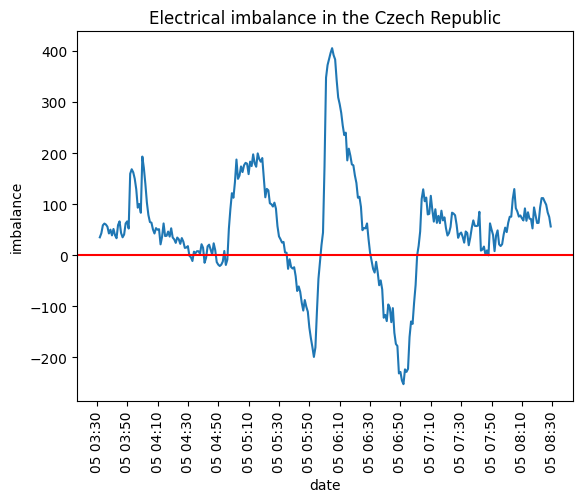

In [88]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# plot a seaborn lineplot of the imbalance and date
sns.lineplot(data=df, x="date", y="imbalance")
# Show only hour and minute on the x axis
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Show the ticks on x axis every 30 minutes
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=20))
# Add a line for the zero imbalance
plt.axhline(y=0, color='r', linestyle='-')
# Display the date on x axis but ticks should be 90 degrees rotated
plt.xticks(rotation=90)
# Add a title
plt.title("Electrical imbalance in the Czech Republic")

# Show the plot
plt.show() 

## Click "Run all" to retrieve the graph with the most recent Imbalance values